In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from aquarel import load_theme


# Using the Aquarel library with some customization for the plots
theme = load_theme("boxy_dark")
theme.set_color(figure_background_color="#181818",
                plot_background_color="#242424")
theme.set_font(family="monospace", size=9)
theme.apply_transforms()
theme.apply()


df = pd.read_csv("Data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# Visualizing the raw attributes distribution
def visualize_raw_data(df:pd.DataFrame, config:dict):

    n_models = len(config)
    n_columns = 3 # Default number of columns
    # Calculate the minimum number of rows to fit the plotting grid
    n_rows = (n_models + n_columns - 1) // n_columns

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, n_rows * 5))
    # Converting the axs objects to a n by m shape, so individual axs would be iterable
    axs = np.array(axs).reshape(n_rows, n_columns)
    
    for i, (column_name, plot_type) in enumerate(config.items()):
        row, col = divmod(i, n_columns)
        ax = axs[row, col]
        
        if plot_type == "bar":
            column_count = pd.DataFrame(df[column_name].value_counts())
            ax.bar(column_count.index, column_count['count'].values)
            ax.set_title(column_name, loc="center")
            
        elif plot_type == "hist":
            ax.hist(df[column_name], bins=15)
            ax.set_title(column_name, loc="center")

    fig.supxlabel("# of Passengers")
    fig.supylabel("Attribute")

    # Remove the remainder empty subplots
    for i in range(n_models, n_rows * n_columns):
        fig.delaxes(axs.flatten()[i])
        
    plt.tight_layout()
    plt.show()

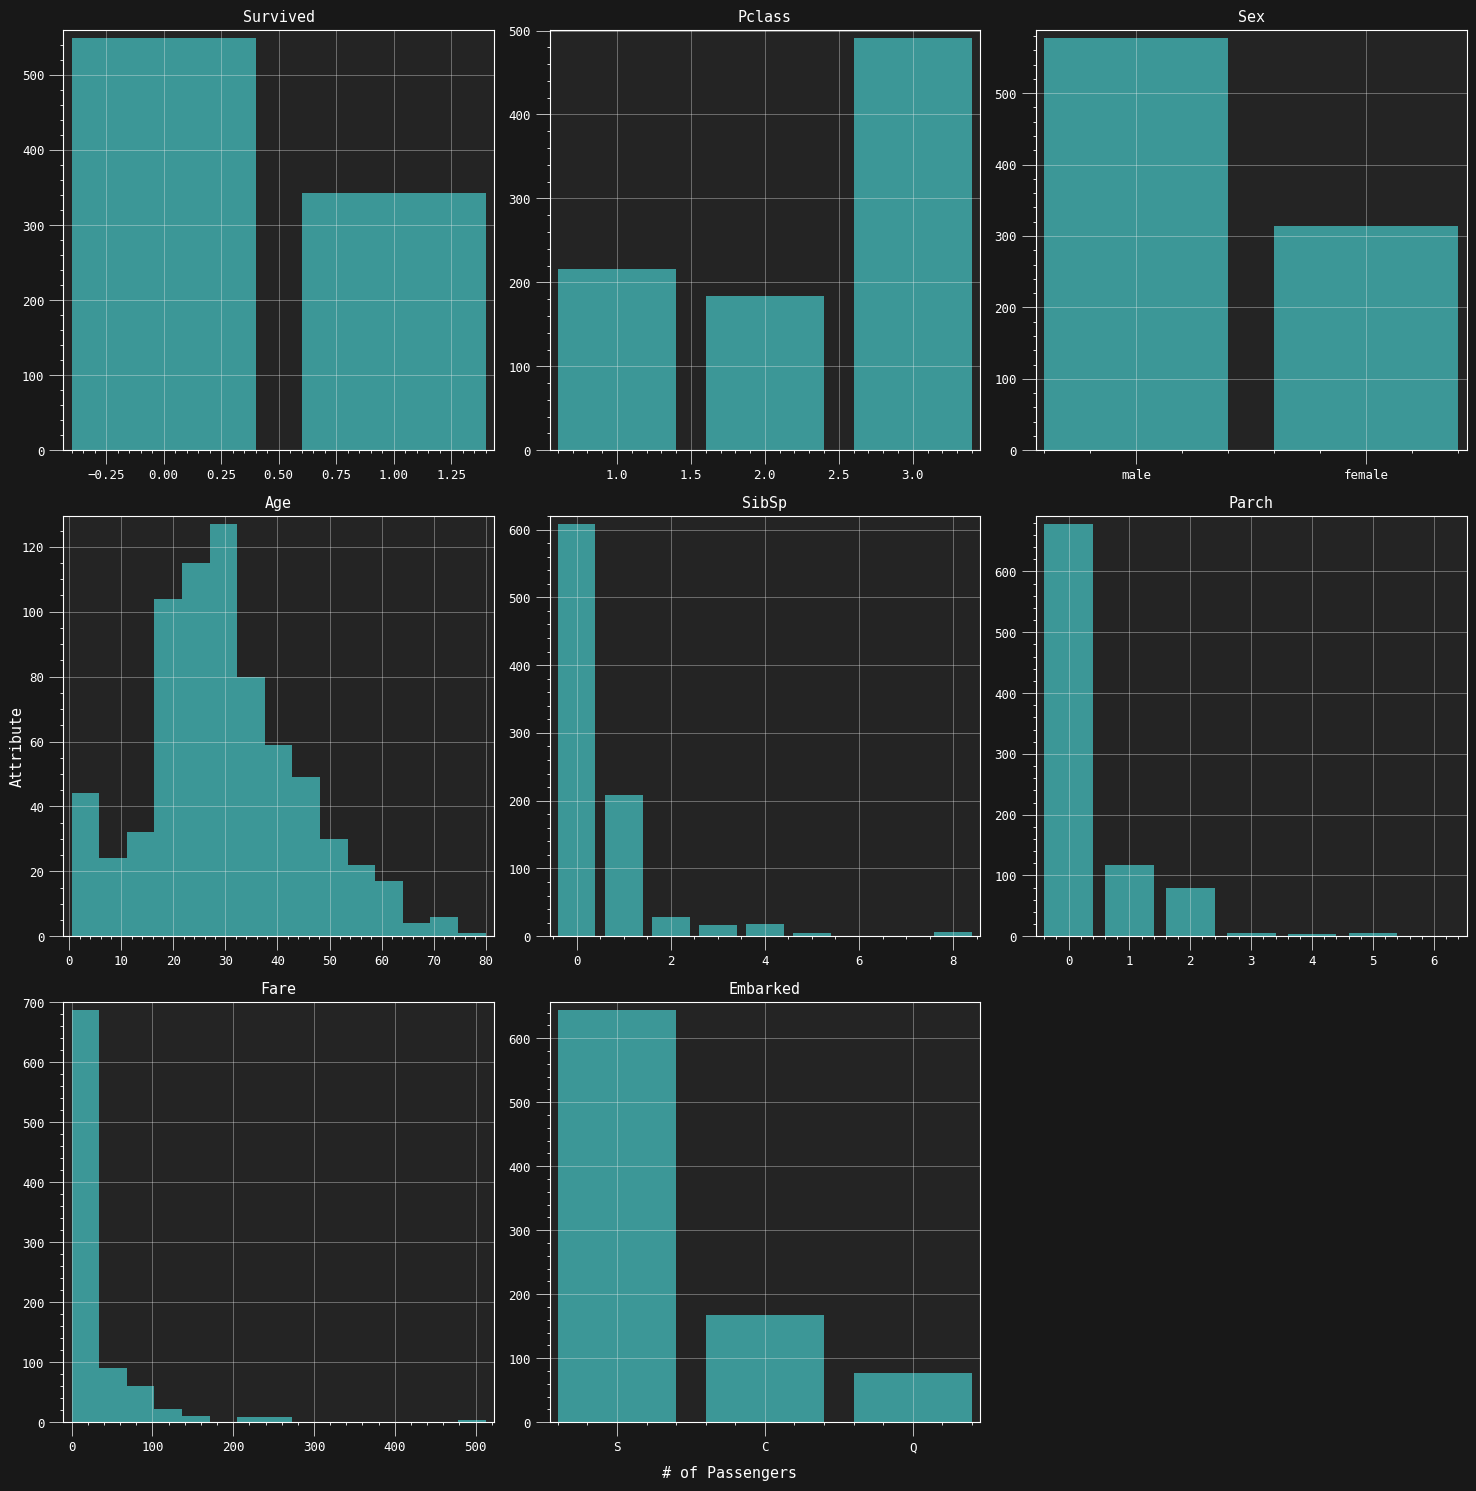

In [5]:
raw_data_config = {
    "Survived": "bar",
    "Pclass": "bar",
    "Sex": "bar",
    "Age": "hist",
    "SibSp": "bar",
    "Parch": "bar",
    "Fare": "hist",
    "Embarked": "bar",
}

visualize_raw_data(df, raw_data_config)

In [6]:
## --- PassengerId --- ##
df = df.drop(columns=["PassengerId"], errors='ignore')


## --- Name --- ##
# Extracting the title
df["Title"] = df["Name"].apply(lambda x: x.split(", ")[1].split(".")[0])
df = df.drop(columns=["Name"])


## --- Age --- ##
# Replacing missing age values with the average
df["Age"] = df["Age"].fillna(int(df["Age"].median()))
# Defining a new feature - age group
age_bins = [0, 3, 12, 20, 60, 200]
age_labels = ["toddler", "child", "teen", "adult", "senior"]
df["AgeGroup"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels);


## --- SibSp & Parch --- ##
# Introducing a new and more meaningful feature
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df = df.drop(columns=["SibSp", "Parch"], errors='ignore');


## --- Ticket & Fare --- ##
# Adding the number of times a ticket was repeated to the dataframe
ticket_count = df["Ticket"].value_counts()
df["TicketCount"] = df["Ticket"].map(ticket_count)
# Adjusting the ticket price
df["AdjustedFare"] = round(df["Fare"] / df["TicketCount"], 4);
df['AdjustedFare'] = df['AdjustedFare'].replace(0, df['AdjustedFare'].median());
# Spliting the passengers to 4 groups based on their wealth
q25, q50, q75 = list(df['AdjustedFare'].quantile([.25, .5, .75]))
print(f"25% Fare Quantile: {q25}")
print(f"50% Fare Quantile: {q50}")
print(f"75% Fare Quantile: {q75}")
fare_bins = [0, q25, q50, q75, df['AdjustedFare'].max()]
fare_labels = ["VeryLow", "Low", "Medium", "High"]
df["Wealth"] = pd.cut(df["AdjustedFare"], bins=fare_bins, labels=fare_labels)
df = df.drop(columns=["Ticket", "Fare", "TicketCount"])


## --- Cabin --- ##
# Extracting deck of residance for each passanger - N/A for NaN
df["Deck"] = df["Cabin"].str[0]
df["Deck"] = df["Deck"].fillna("N/A")
df = df.drop(columns=["Cabin"])


## --- Embarked --- ##
# Replacing embarked locations with their full name
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode().iloc[0])
location_dict = {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}
df["Embarked"] = df["Embarked"].replace(location_dict)

25% Fare Quantile: 7.775
50% Fare Quantile: 8.85
75% Fare Quantile: 24.2882


In [7]:
df.sample(5)

,Survived,Pclass,Sex,Age,Embarked,Title,AgeGroup,FamilySize,AdjustedFare,Wealth,Deck
105,0,3,male,28.0,Southampton,Mr,adult,1,7.8958,Low,N/A
272,1,2,female,41.0,Southampton,Mrs,adult,2,9.7500,Medium,N/A
129,0,3,male,45.0,Southampton,Mr,adult,1,6.9750,VeryLow,N/A
42,0,3,male,28.0,Cherbourg,Mr,adult,1,7.8958,Low,N/A
823,1,3,female,27.0,Southampton,Mrs,adult,2,6.2375,VeryLow,E


In [8]:
# Number of passengers holding a certain title to their name
df['Title'].value_counts()
common_titles = ["Mr", "Miss", "Mrs", "Master"]
# If title is not among the list above, change it to rare
df['Title'] = df['Title'].apply(lambda x: x if x in common_titles else "Rare")

In [9]:
# A function to plot the survival rate based on the given column values
def group_plot_survival(df=df, column="Sex"):
    
    grouped_attribute = df.groupby(column, observed=False)['Survived']
    attribute_survival_rate = grouped_attribute.mean()
    
    grouped_plot = attribute_survival_rate.plot(
        kind="bar",
        ylabel="Chance of Survival",
        xlabel=str(column),
        title=str(column),
        rot=0)
    
    return plt.show(grouped_plot)

In [10]:
df.head()

,Survived,Pclass,Sex,Age,Embarked,Title,AgeGroup,FamilySize,AdjustedFare,Wealth,Deck
0,0,3,male,22.0,Southampton,Mr,adult,2,7.2500,VeryLow,N/A
1,1,1,female,38.0,Cherbourg,Mrs,adult,2,71.2833,High,C
2,1,3,female,26.0,Southampton,Miss,adult,1,7.9250,Low,N/A
3,1,1,female,35.0,Southampton,Mrs,adult,2,26.5500,High,C
4,0,3,male,35.0,Southampton,Mr,adult,1,8.0500,Low,N/A


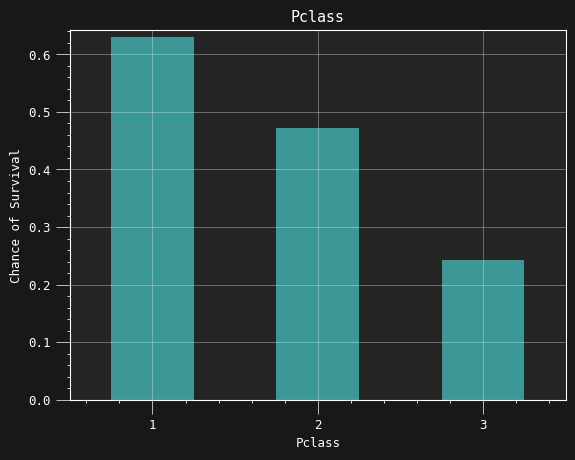

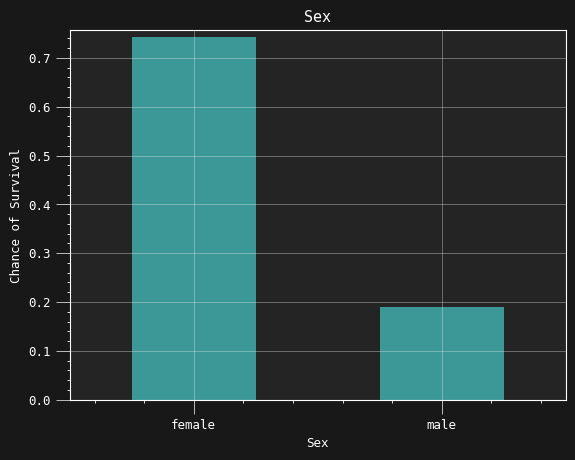

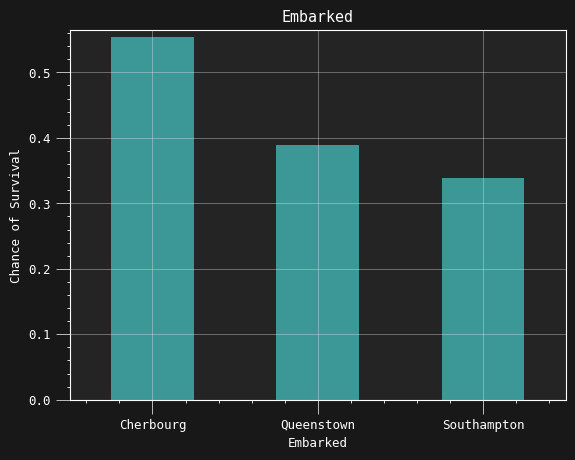

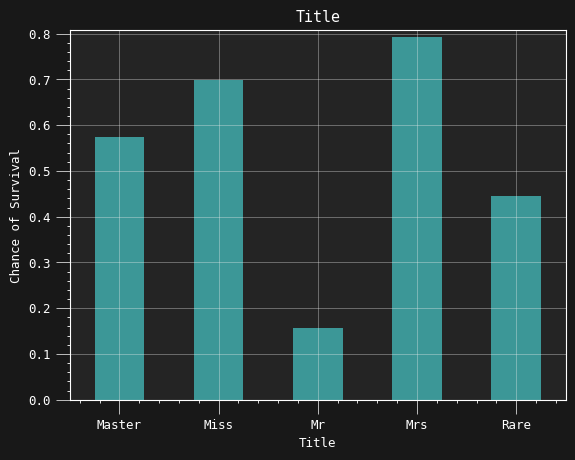

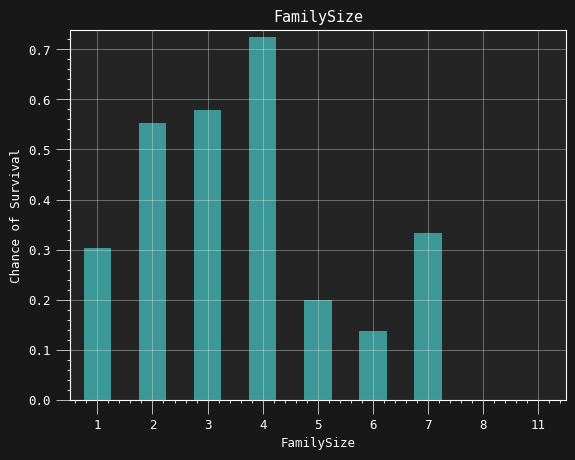

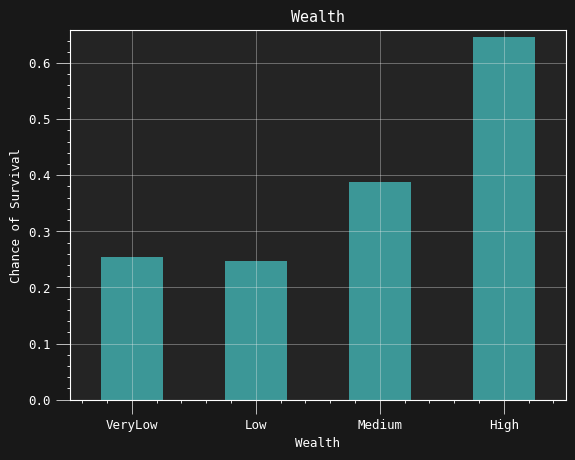

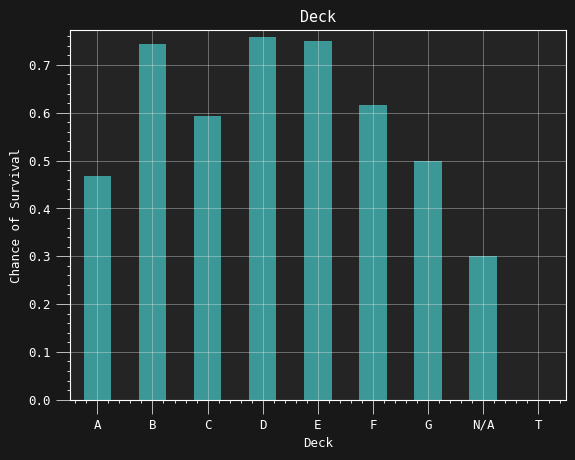

In [11]:
bar_plot_config = [
    (df, "Pclass"),
    (df, "Sex"),
    (df, "Embarked"),
    (df, "Title"),
    (df, "FamilySize"),
    (df, "Wealth"),
    (df, "Deck"),
]

for df, column in bar_plot_config:
    group_plot_survival(df, column)

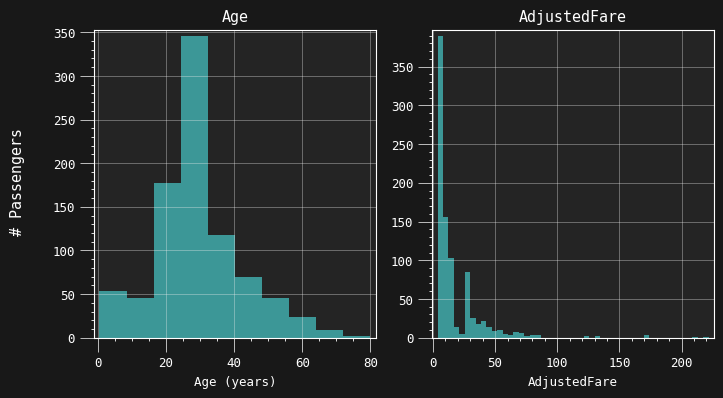

In [12]:
# Plotting the age and fare distribution
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))
ax1.hist(df['Age'], bins=10)
ax1.set_xlabel('Age (years)')
ax1.set_title('Age')
ax2.hist(df['AdjustedFare'], bins=50)
ax2.set_xlabel('AdjustedFare')
ax2.set_title('AdjustedFare')
fig.supylabel('# Passengers')
plt.show(fig)

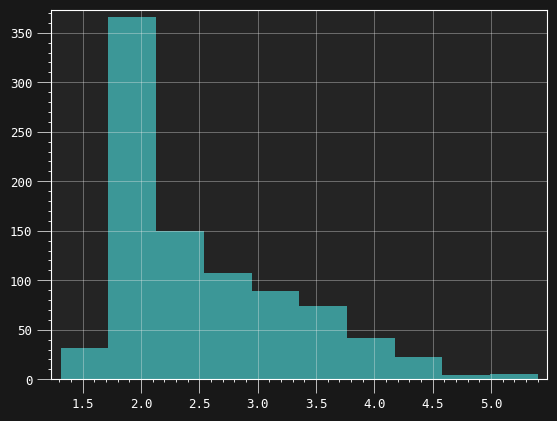

In [13]:
# Addressing the skewness of the fare values by log
df['LogFare'] = np.log(df['AdjustedFare'])
plt.show(df['LogFare'].hist())

In [14]:
# Number of passengers based on their embarked location and class
grouped_embarked_pclass = df.groupby("Pclass")["Embarked"].value_counts()
grouped_embarked_pclass = pd.DataFrame(grouped_embarked_pclass).sort_values(by=["Pclass", "Embarked"])
grouped_embarked_pclass

count
Pclass Embarked          
1      Cherbourg       85
       Queenstown       2
       Southampton    129
2      Cherbourg       17
       Queenstown       3
       Southampton    164
3      Cherbourg       66
       Queenstown      72
       Southampton    353

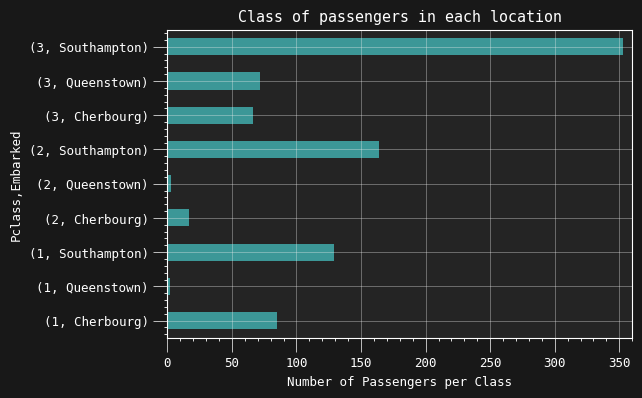

In [15]:
grouped_embarked_pclass_plot = grouped_embarked_pclass.plot(
    kind="barh",
    xlabel="Number of Passengers per Class",
    title="Class of passengers in each location",
    rot=0,
    legend=False,
    figsize=(6, 4))

plt.show(grouped_embarked_pclass_plot)

In [16]:
# Survival based on class and gender
grouped_pclass_sex_survived = pd.DataFrame(df.groupby(['Pclass', 'Sex'])['Survived'].mean())
grouped_pclass_sex_survived

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

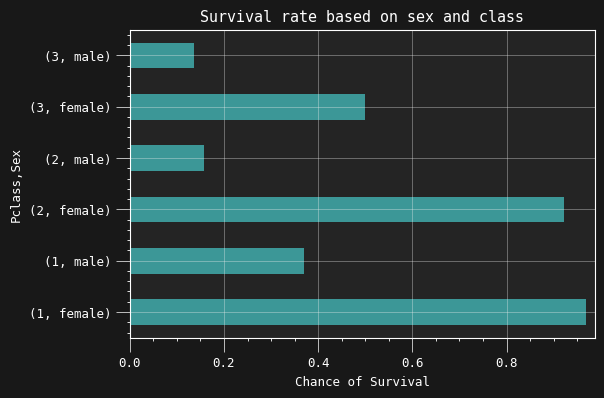

In [17]:
grouped_pclass_sex_survived_plot = grouped_pclass_sex_survived.plot(
    kind="barh",
    xlabel="Chance of Survival",
    title="Survival rate based on sex and class",
    rot=0,
    legend=False,
    figsize=(6, 4))

plt.show(grouped_pclass_sex_survived_plot)

In [18]:
def custome_ohe(df:pd.DataFrame, column:str, drop_original:bool=False):
    
    try:
        target_column = df[column]
        target_values = list(target_column.unique())
        for val in target_values:
            feature_title = f"{column}_{val}"
            df[feature_title] = df[column].map(
                lambda x: 1 if x == val else 0
            )
        if drop_original == True:
            df.drop(columns=[column], inplace=True, errors="ignore")
    except:
        if column not in df.columns:
            print(f"Column {column} does not exist in the dataframe.")
        else:
            print("The function is unable to one-hot-encode the column.")

In [19]:
ohe_columns = ['Pclass', 'Sex', 'Embarked',
               'Deck', 'AgeGroup', 'Title',
               'Wealth']

for col in ohe_columns:
    custome_ohe(df=df, column=col, drop_original=True)

df.head()

,Survived,Age,FamilySize,AdjustedFare,LogFare,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,...,AgeGroup_senior,Title_Mr,Title_Mrs,Title_Miss,Title_Master,Title_Rare,Wealth_VeryLow,Wealth_High,Wealth_Low,Wealth_Medium
0,0,22.0,2,7.2500,1.981001,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,1,38.0,2,71.2833,4.266662,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,1,26.0,1,7.9250,2.070022,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,1,35.0,2,26.5500,3.279030,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,0,35.0,1,8.0500,2.085672,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


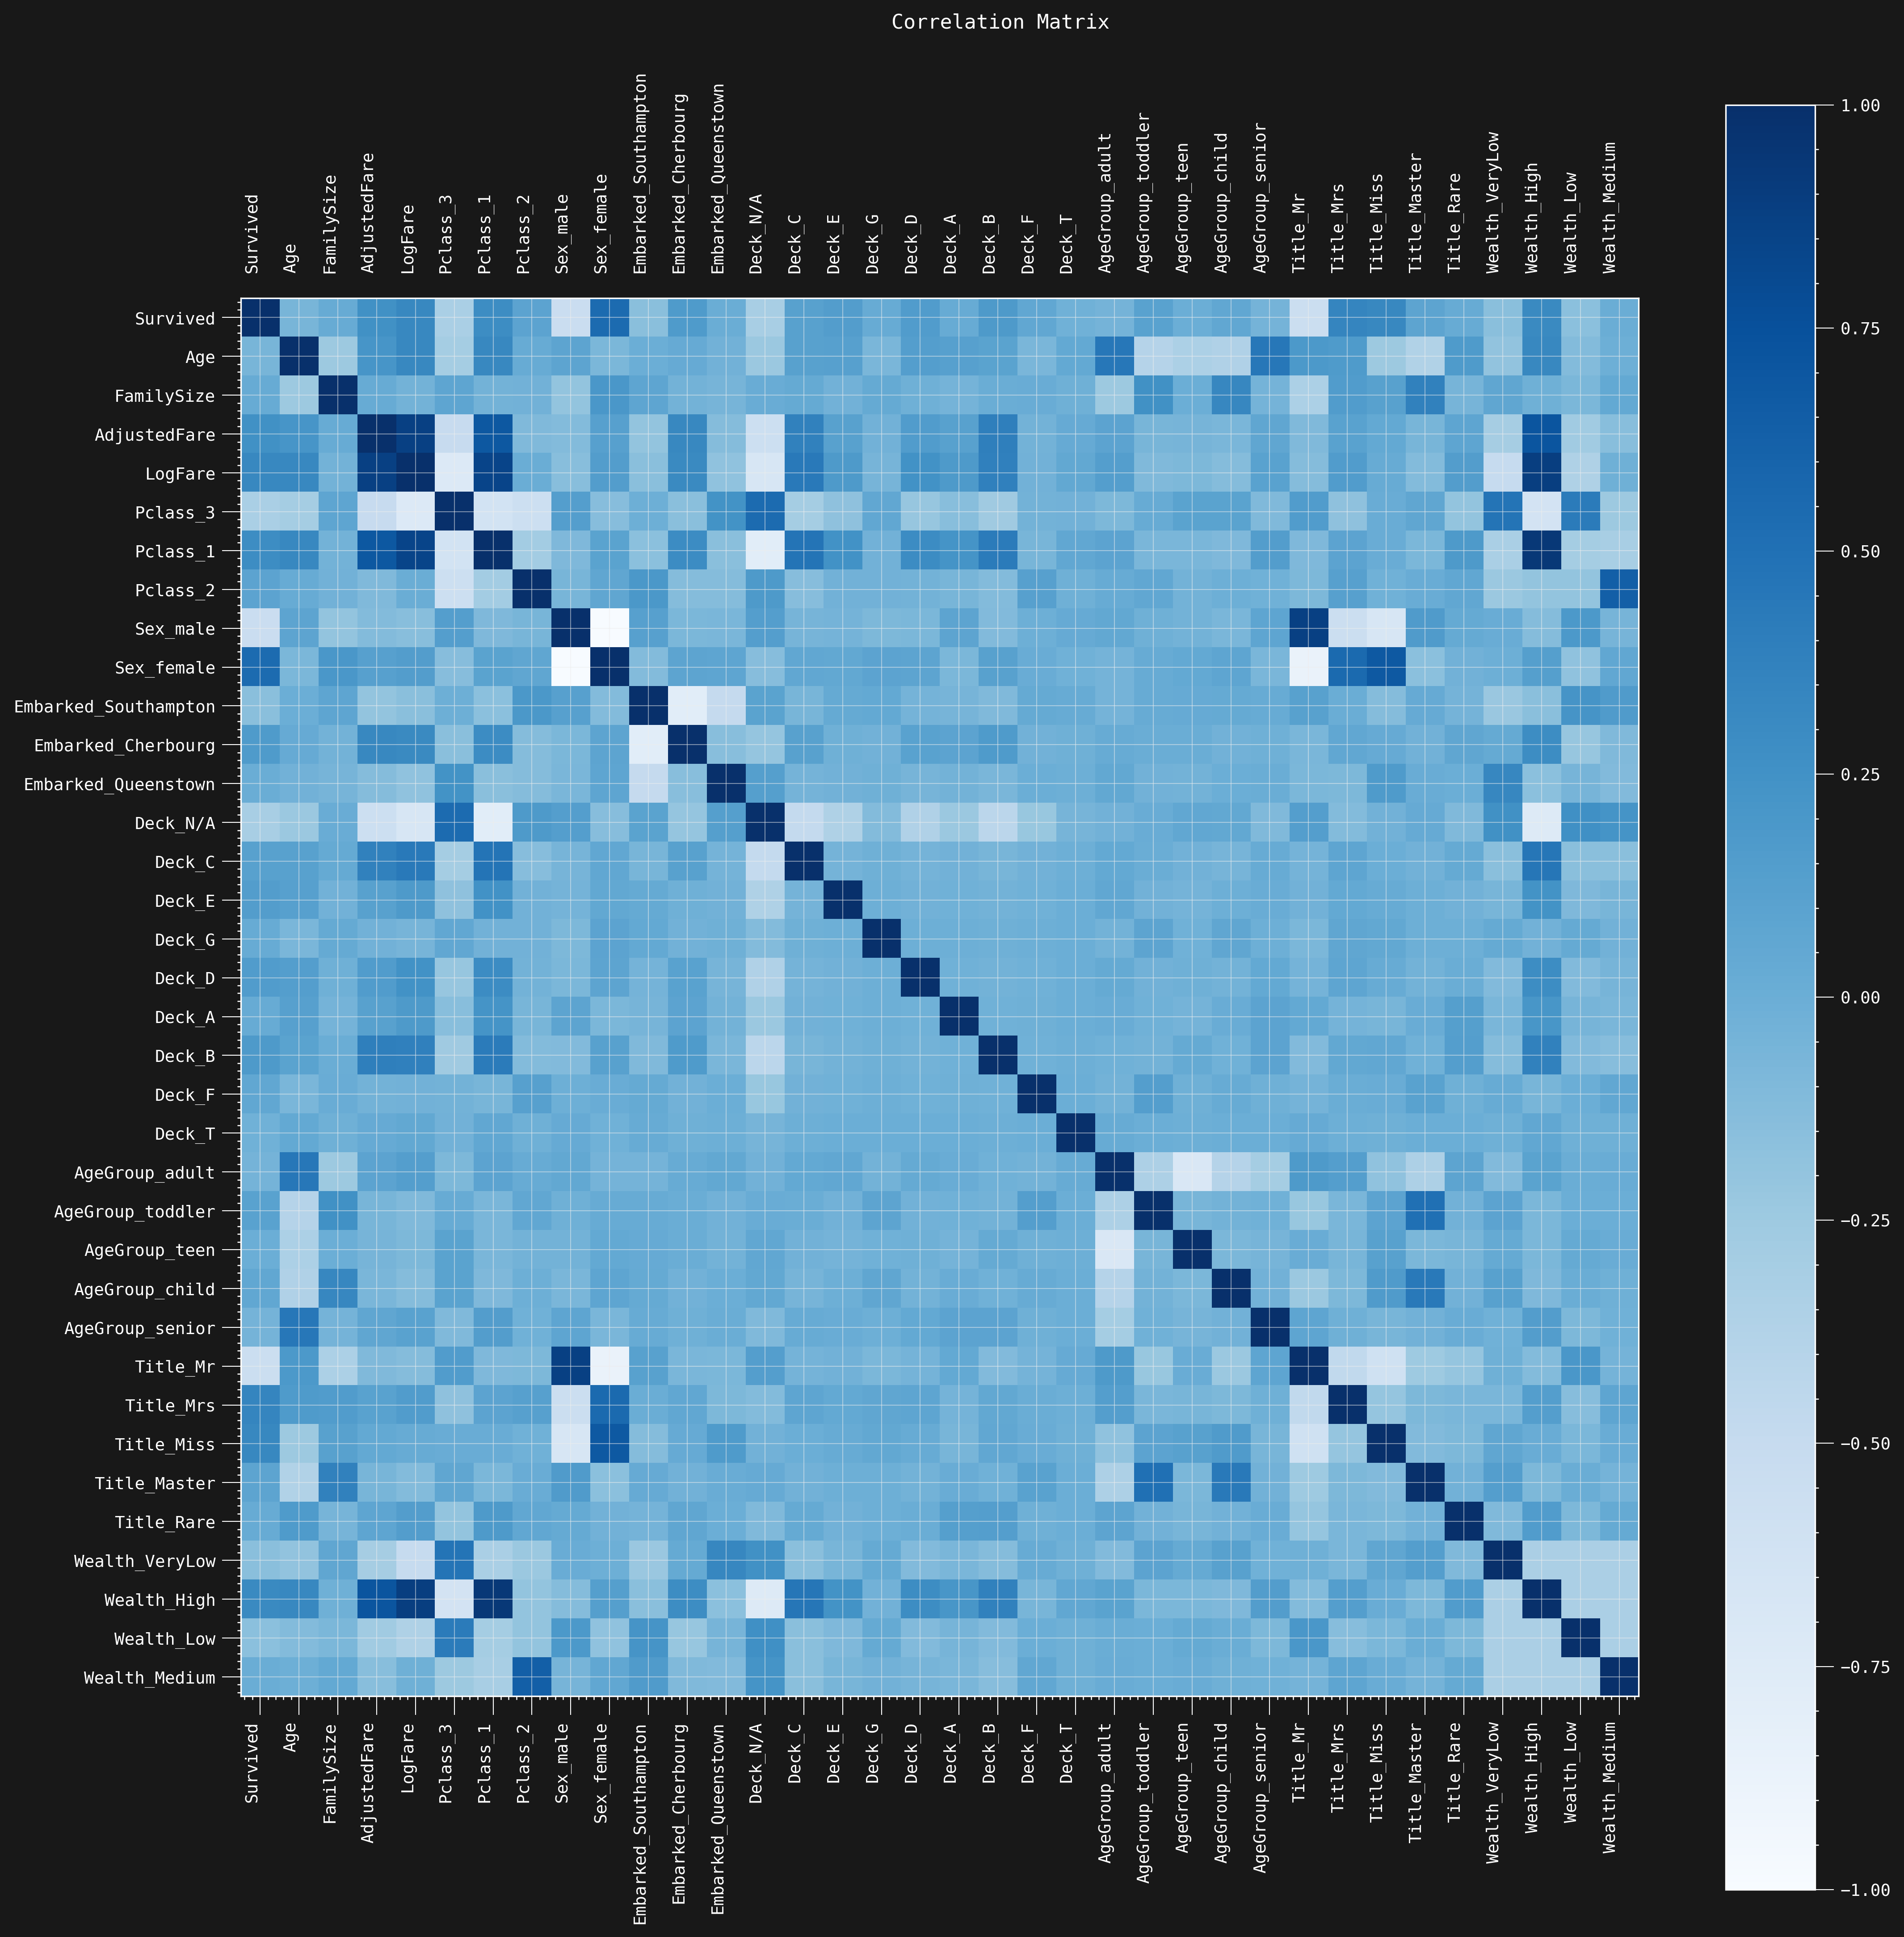

In [20]:
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(15, 15), dpi=300)
corr_mat = ax.imshow(df_corr, cmap='Blues')
plt.colorbar(corr_mat)
features = [x for x in df_corr.columns]
plt.xticks(range(len(df_corr)), features, rotation=90, ha='right')
plt.yticks(range(len(df_corr)), features)
plt.tick_params(labeltop=True)
plt.suptitle("Correlation Matrix")

plt.tight_layout()
plt.show(fig)

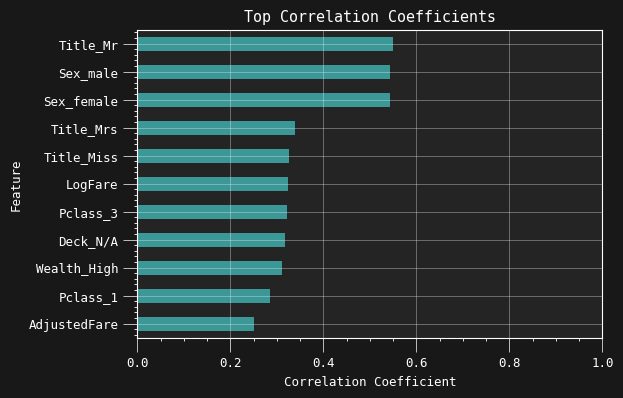

In [21]:
corr_fig_top = abs(df_corr["Survived"]).sort_values()[-12:-1].plot(
    kind="barh",
    xlabel="Correlation Coefficient",
    ylabel="Feature",
    xlim=[0, 1],
    title="Top Correlation Coefficients",
    figsize=(6, 4))

plt.show(corr_fig_top)